# Predicting House Sale Prices

In this project, we will explore different ways to improve machine learning model to predict house price, by focusing on feature engineering, feature selection, and training a model with multiple k-values using kFold cross validation.

We will use the housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected [here](https://doi.org/10.1080/10691898.2011.11889627). You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

Let's begin!

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('AmesHousing.tsv', delimiter='\t')

Now we will create several functions as the barebone of our data pipeline. We will need three functions to:

1. transform the original dataframe features
2. select desired features for training from the transformed features
3. train and test based on the selected features

In [3]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    return rmse

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

Since it worked perfectly, let's now start to removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. Update transform_features() so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. We also need to remove any columns that leak information about the sale (e.g. like the year the sale happened).

In general, the goal of this function is to:

* remove features that we don't want to use in the model, just based on the number of missing values or data leakage
* transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
* create new features by combining other features

# Feature Engineering

Let's decide how we are going to handle missing values!

* All columns:
    * Drop any with 5% or more missing values for now.
* Text columns:
    * Drop any with 1 or more missing values for now.
* Numerical columns:
    * For columns with missing values, fill in with the most common value in that column
    
### 1. All columns

Drop any with 5% or more missing values for now.

In [4]:
num_missing = df.isnull().sum()

#    Filter Series to columns containing >5% missing values
drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()

#    Drop those columns from the data frame.
df = df.drop(drop_missing_cols.index, axis=1)

### 2. Text columns

Drop any with 1 or more missing values for now.

In [5]:
text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)

## Filter Series to columns containing *any* missing values
drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]

df = df.drop(drop_missing_cols_2.index, axis=1)

### 3. Numerical columns

For columns with missing values, fill in with the most common value in that column

In [6]:
num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
fixable_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [7]:
## Compute the most common value for each column in `fixable_nmeric_missing_cols`.
replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [8]:
df = df.fillna(replacement_values_dict)
df.isnull().sum().value_counts()

0    64
dtype: int64

## New Features

What new features can we create, that better capture the information in some of the features?

For example, we have the following features:

* Yr Sold
* Year Built
* Year Remod/Add

We can calculate years between these events to better capture the information provided:

* years_since_built = Yr Sold - Year Built
* years_since_remod = Yr Sold - Year Remod/Add

Once we have produced these new features, we can then delete the original ones from our dataframe. We should also validate these features after we create them to ensure they make sense (i.e. no negative values).

In [9]:
df['years_since_built'] = df['Yr Sold'] - df['Year Built']
df['years_since_built'].describe()

count    2930.000000
mean       36.434130
std        30.291357
min        -1.000000
25%         7.000000
50%        34.000000
75%        54.000000
max       136.000000
Name: years_since_built, dtype: float64

In [10]:
def identify_negative_val(df: pd.DataFrame, feat:str)->pd.DataFrame:
    return df.loc[df[feat] < 0, [feat]]

identify_negative_val(df, 'years_since_built')
# we will drop this value after

,years_since_built
2180,-1


In [11]:
# create years_since_remod
df['years_since_remod'] = df['Yr Sold'] - df['Year Remod/Add']
df['years_since_remod'].describe()

count    2930.000000
mean       23.523891
std        20.858846
min        -2.000000
25%         4.000000
50%        15.000000
75%        42.750000
max        60.000000
Name: years_since_remod, dtype: float64

In [12]:
identify_negative_val(df, 'years_since_remod')

,years_since_remod
1702,-1
2180,-2
2181,-1


In [13]:
## Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0)

## No longer need original year columns
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

In [14]:
## Drop columns that aren't useful for ML
df = df.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

In [15]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.36731241307

## Feature Selection

Now that we have cleaned and transformed the numerical data in our dataset, let's look at feature selection for these numerical features.

To begin, let's look at the correlations of the features in our data. What features correlate strongly with `SalePrice`?

Are there features that should be converted to categorical data types? How do these categorical features "correlate" with `SalePrice`?

Let's update our `select_features()` function with all of the above and then re-run our model.

In [16]:
numerical_df = transform_df.select_dtypes(include=['int', 'float'])
numerical_df.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,2010,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,2010,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,2010,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,2010,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,2010,189900,13,12


In [17]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2         0.006127
Misc Val             0.019273
Yr Sold              0.030358
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice 

In [18]:
## Let's only keep columns with a correlation coefficient of 
#  larger than 0.4 (arbitrary, worth experimenting later!)
abs_corr_coeffs[abs_corr_coeffs > 0.4]

BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

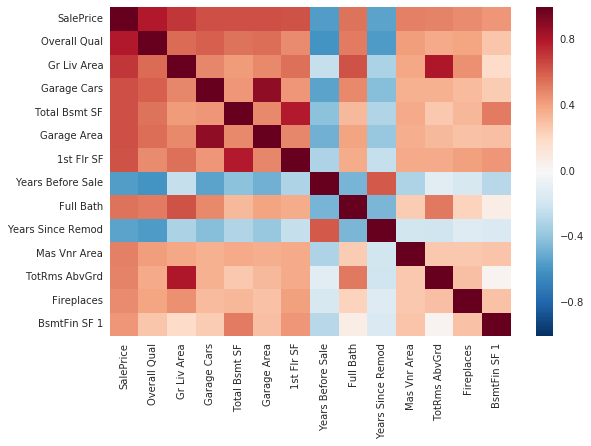

In [19]:
# create a correlation heatmap of the numerical features
corr_matrix = numerical_df[abs_corr_coeffs[abs_corr_coeffs > 0.4].sort_values(ascending=False).index].corr()
sns.heatmap(corr_matrix)

In [20]:
## Drop columns with less than 0.4 correlation with SalePrice
transform_df = transform_df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)

Which categorical columns should we keep?
The ones that have a few unique values but more than 95% of the values in the column belong to a specific category.

This is because, if a categorical column has hundreds of unique values (or categories), when we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [21]:
## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [22]:
## Which categorical columns have we still carried with us? We'll test tehse 
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

## How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
## Aribtrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis=1)

Now, we should update `select_features()`

In [23]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

33367.28718340324

## Training and Testing

Next, let's update the train_and_test function to incorporate cross validation. We can incorporate several types:

* k = 0: holdout validation
    * assign the first 1460 rows to train and the remainder to test
    * train on train; test on test
    * return the RMSE
* k = 1: simple cross validation
    * shuffle the row ordering
    * assign the first 1460 rows to fold_one and the remainder to fold_two
    * train on fold_one; test on fold_two
    * train on fold_two; test on fold_one
    * return the average RMSE
* k > 1: k-fold cross validation
    * perform k-fold cross validation using k folds
* return the avereage RMSE

In [24]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[36904.56679436469, 24773.31484982088, 27326.680355852917, 26077.52415102557]


28770.521537766017

# Conclusion

In this project, we have concluded our experiment with emphasis of feature engineering, feature extraction, and training a linear regression model using k-Fold cross validation.
We can still explore this dataset further by improving our feature engineering techniques, and research different ways of better feature selection with categorical column, for example.